In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 5.0 MB/s eta 0:00:00


In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [3]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [50]:
# Config
SUB_FILE_NAME = "val13-3"
SAVE_SUB = True
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SAVE_DF = False
SAVE_DF_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/Val_20230429")

# データ読み込み

In [6]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

# 特徴抽出後のデータ
umap_basic_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_train.pkl")
umap_basic_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_test.pkl")
train_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_train_sentinel_minmaxDiff.pkl")
test_sentinel = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230428_test_sentinel_minmaxDiff.pkl")
train_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_train_landsat2_2000to2020.pkl")
test_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_test_landsat2_2000to2020.pkl")
train_landsat_norm = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_train_landsat3_normalized.pkl")
test_landsat_norm = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_test_landsat3_normalized.pkl")
train_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_train_landsat4_minmax.pkl")
test_landsat_minmax = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_test_landsat4_minmax.pkl")

train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [7]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [8]:
train[f"log_cover"] = np.log1p(train["cover"])

## データの日付とLandsat画像の日付の差

In [9]:
# 学習データの時期の日付は全部15日にする
train["date"] = train["year"].astype(int).astype(str) + "/" + train["month"].astype(int).astype(str) + "/15"
train["date"] = pd.to_datetime(train["date"])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,log_cover,date
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10,0.048790,2011-09-15
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13,0.545227,2009-07-15


In [10]:
train["Date_Acquired"] = pd.to_datetime(train["Date_Acquired"], format="%Y%m%d")
train["Date_Acquired"].head(2)

0   2012-01-18
1   2009-07-06
Name: Date_Acquired, dtype: datetime64[ns]

In [11]:
train["date_diff"] = (train["Date_Acquired"] - train["date"]) / dt.timedelta(days=1)
train["date_diff"].head(2)

0    125.0
1     -9.0
Name: date_diff, dtype: float64

## 特徴抽出後のデータを結合

In [12]:
# いらんデータ消しておく
cols_landsat_2000to2020 = [col for col in train_landsat_2000to2020.columns if not "MINMAX" in col]
train_landsat_2000to2020 = train_landsat_2000to2020[cols_landsat_2000to2020]
test_landsat_2000to2020 = test_landsat_2000to2020[cols_landsat_2000to2020]

In [13]:
print(train.shape)
print(train_landsat_minmax.shape)
print(test.shape)
print(test_landsat_minmax.shape)
train_landsat_minmax.head(2)

(14140, 3467)
(14140, 100)
(4039, 3463)
(4039, 100)


,MINMAX_CTVI_mean,MINMAX_CTVI_std,MINMAX_PPR_mean,MINMAX_PPR_std,MINMAX_TIRS2_mean,MINMAX_TIRS2_std,MINMAX_EVI_mean,MINMAX_EVI_std,MINMAX_SIPI2_mean,MINMAX_SIPI2_std,...,MINMAX_MCARI2_mean,MINMAX_MCARI2_std,MINMAX_BWDRVI_mean,MINMAX_BWDRVI_std,MINMAX_MCARI1_mean,MINMAX_MCARI1_std,MINMAX_SWIR2_mean,MINMAX_SWIR2_std,MINMAX_Ferric_Oxides_mean,MINMAX_Ferric_Oxides_std
0,0.134025,0.111810,0.080669,0.086960,0.339952,0.359248,0.042444,0.058448,1.817571,2.293036,...,0.973567,0.848198,0.028040,0.035760,11.012710,19.343378,1.181849,1.944656,0.056972,0.049894
1,0.035624,0.047987,0.046483,0.045414,0.318083,0.318512,0.187296,0.193427,4.727555,6.033570,...,0.258074,0.266281,0.045798,0.048732,21.390165,24.260161,0.475902,0.772107,0.048084,0.053776


In [14]:
train = train.join([
    umap_basic_train,
    train_sentinel,
    train_landsat_minmax,
    train_landsat_2000to2020,
    train_landsat_norm,
])
test = test.join([
    umap_basic_test,
    test_sentinel,
    test_landsat_minmax,
    test_landsat_2000to2020,
    train_landsat_norm,
])
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,NLI_norm,NormG_norm,NormR_norm,PPR_norm,PSNDc2_norm,RDVI_norm,IF_norm,SLAVI_norm,SIPI2_norm,VARIgreen_norm
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-1.451049,0.475077,0.296024,-1.109615,-0.750047,-0.052587,0.127271,-0.406854,0.116049,-0.049049
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,1.864528,-3.654105,-1.126482,2.711313,5.444383,9.581726,12.557637,1.335754,-4.261068,0.143220


In [15]:
umap_basic_train.head()

,dim0,dim1,temp_monthly
0,1.788618,6.597842,27.9
1,-10.111396,6.170877,29.2
2,21.165592,6.679852,25.3
3,-6.996612,9.728025,16.7
4,-6.822807,9.109682,16.7


## 使用する特徴量

In [16]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
# cols_landsat = train.columns.to_list()[25:88]
cols_landsat = ["sunAzimuth", "sunElevation", "Landsat_num", "date_diff"]
cols_landsat_2000to2020 = train_landsat_2000to2020.columns.to_list()
cols_landsat_minmax = train_landsat_minmax.columns.to_list()
cols_landsat_norm = train_landsat_norm.columns.to_list()

cols_sentinel = train.columns.to_list()[88:313]
cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_sentinel_minmax = train_sentinel.columns.to_list()

cols_umap = ["temp_monthly"]

cols_use =\
 cols_base +\
 cols_landsat_2000to2020 +\
 cols_landsat_minmax +\
 cols_landsat_norm +\
 cols_sentinel +\
 cols_sentinel_minmax +\
 cols_umap +\
 ["log_cover"] # + cols_sentinel

cols_remove = [
    "YMD",
    "month",
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    "mesh20"
]
cols_use = [col for col in cols_use if not col in cols_remove]

# Landsatの関係なさそうな指標を抜く
cols_remove2_raw = [
    "NBR",
    "NBR2",
    "Alteration",
    "DSWI",
    "DSWI_5",
    "Fe3",
    "Ferric_Oxides",
    "Ferrous_Silicates",
    "Gossan"
]
cols_remove2 = []
for rm_word in cols_remove2_raw:
    cols_remove2 += [col for col in cols_use if rm_word in col]
cols_use = [col for col in cols_use if not col in cols_remove2]

# 重複を省く（一応）
cols_use = sorted(list(set(cols_use)))

cols_use

['AVI_norm',
 'BWDRVI_norm',
 'Blue_norm',
 'CI_norm',
 'CRI550_norm',
 'CTVI_norm',
 'CVI_norm',
 'Chlgreen_norm',
 'Chlred_edge_norm',
 'Cigreen_norm',
 'Cirededge_norm',
 'D678_500_norm',
 'DVIMSS_norm',
 'EVI_norm',
 'GARI_norm',
 'GEMI_norm',
 'GLI_norm',
 'GVMI_norm',
 'Green_norm',
 'H_norm',
 'IF_norm',
 'IR550_norm',
 'MCARI1_norm',
 'MCARI2_norm',
 'MED_AFRI1600',
 'MED_AOT',
 'MED_ARI',
 'MED_ARVI',
 'MED_AVI',
 'MED_AVI_median',
 'MED_AVI_std',
 'MED_B02',
 'MED_B03',
 'MED_B04',
 'MED_B05',
 'MED_B06',
 'MED_B07',
 'MED_B11',
 'MED_B12',
 'MED_B8A',
 'MED_BB1',
 'MED_BGI',
 'MED_BNDVI',
 'MED_BOA',
 'MED_BRI',
 'MED_BWDRVI',
 'MED_BWDRVI_median',
 'MED_BWDRVI_std',
 'MED_Bcc',
 'MED_Blue_median',
 'MED_Blue_std',
 'MED_CARI',
 'MED_CI_median',
 'MED_CI_std',
 'MED_CIgreen',
 'MED_CIrededge',
 'MED_CLD',
 'MED_CRI550_median',
 'MED_CRI550_std',
 'MED_CRred',
 'MED_CSI',
 'MED_CTVI_median',
 'MED_CTVI_std',
 'MED_CVI',
 'MED_CVI_median',
 'MED_CVI_std',
 'MED_Chlgreen_median

In [17]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Columns: 386 entries, AVI_norm to year
dtypes: float32(170), float64(216)
memory usage: 32.5 MB


In [18]:
cols_obj = ["cover", "log_cover"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 384


In [19]:
corr = train[features].corr()
threshold = 0.98
drop_numeric_cols=[]
pair=[]
for col in features:
    # if col in cat_features:
    #     continue
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != features[i] :
            print(f"{col} and {features[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(features[i])
                drop_numeric_cols.append(col) 
features = list(set(features)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(features))
del drop_numeric_cols
del pair

features

BWDRVI_norm and CVI_norm are highly correlated...
BWDRVI_norm and Cigreen_norm are highly correlated...
BWDRVI_norm and PSNDc2_norm are highly correlated...
CVI_norm and BWDRVI_norm are highly correlated...
CVI_norm and Cigreen_norm are highly correlated...
Cigreen_norm and BWDRVI_norm are highly correlated...
Cigreen_norm and CVI_norm are highly correlated...
MED_B03 and MED_SB550 are highly correlated...
MED_B04 and MED_BB1 are highly correlated...
MED_B04 and MED_TCI are highly correlated...
MED_B05 and MED_CARI are highly correlated...
MED_B06 and MED_B07 are highly correlated...
MED_B06 and MED_B8A are highly correlated...
MED_B07 and MED_B06 are highly correlated...
MED_B07 and MED_B8A are highly correlated...
MED_B8A and MED_B06 are highly correlated...
MED_B8A and MED_B07 are highly correlated...
MED_BB1 and MED_B04 are highly correlated...
MED_BB1 and MED_TCI are highly correlated...
MED_BWDRVI_median and MED_PSNDc2_median are highly correlated...
MED_BWDRVI_std and MED_PSNDc2

['aicial_length',
 'MED_SLAVI_std',
 'MINMAX_RDVI_std',
 'MINMAXDiff_MCARI_MTVI2',
 'cliff_length',
 'MED_CTVI_std',
 'depth_original',
 'MED_WVP',
 'MINMAX_VARIgreen_std',
 'MINMAX_NLI_std',
 'MED_mCRIG_median',
 'river_dist',
 'MINMAX_mCRIG_mean',
 'MED_NIR_std',
 'MINMAXDiff_MSBI',
 'MINMAXDiff_MCARI2',
 'MINMAX_Red_mean',
 'MINMAXDiff_BRI',
 'SIPI2_norm',
 'year',
 'MED_SLAVI_median',
 'MINMAX_CVI_std',
 'MINMAX_DVIMSS_mean',
 'CRI550_norm',
 'RDVI_norm',
 'MINMAX_GVMI_mean',
 'MED_NormG_std',
 'MINMAXDiff_CARI',
 'MED_MIRBI',
 'MED_MCARI2_median',
 'MINMAXDiff_ExG',
 'MED_TIRS2_median',
 'MINMAX_Cigreen_std',
 'MINMAX_EVI_std',
 'MINMAXDiff_RGR',
 'MED_NDII',
 'MED_NDRE',
 'NLI_norm',
 'MED_D678_500',
 'MINMAXDiff_ARVI',
 'MINMAXDiff_AVI',
 'warm_sst',
 'MED_NormG_median',
 'MINMAX_TIRS2_std',
 'MINMAX_Chlred_edge_mean',
 'MINMAX_MVI_mean',
 'NormG_norm',
 'MED_CLD',
 'SLAVI_norm',
 'MINMAX_GEMI_std',
 'temp_monthly',
 'MED_NDSI',
 'MED_ARVI',
 'MED_CSI',
 'MINMAX_Chlred_edge_std'

# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [20]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, cv=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    y_pred_val_all = np.zeros(len(y))
    y_pred_val_all[:] = np.nan

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            lgb.early_stopping(100),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        y_pred_val_all[val_idx] = y_pred
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)
        
        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean, y_pred_val_all

In [21]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [22]:
# 最終的なスコアを入れるやつ
y_test_pred_final = np.zeros(len(test))
y_test_pred_final[:] = np.nan
y_val_pred_final = np.zeros(len(train))
y_val_pred_final[:] = np.nan

## パターン1（depth_originalが欠損）

In [23]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 14, 
    'n_estimators': 4000, 
    'learning_rate': 0.017249570940885327, 
    'lambda_l1': 0.07458308290764872, 
    'num_leaves': 170, 
    'colsample_bytree': 0.6731079655436575,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

説明変数の数（修正前） 350
説明変数の数（修正後） 349
##############################
● CV0
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00174631
[1000]	valid_0's fair: 0.00171222
Early stopping, best iteration is:
[1347]	valid_0's fair: 0.00171002
0.15316979741702197


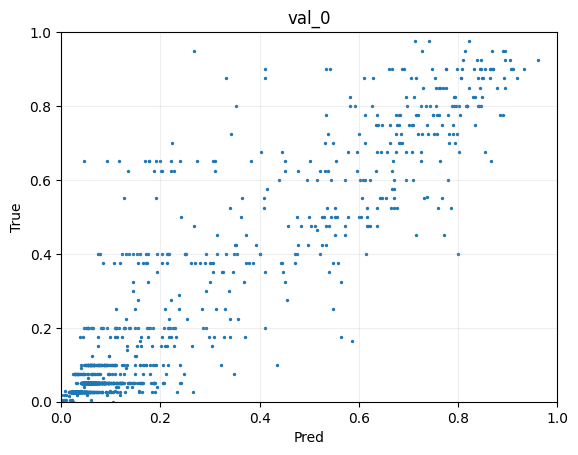

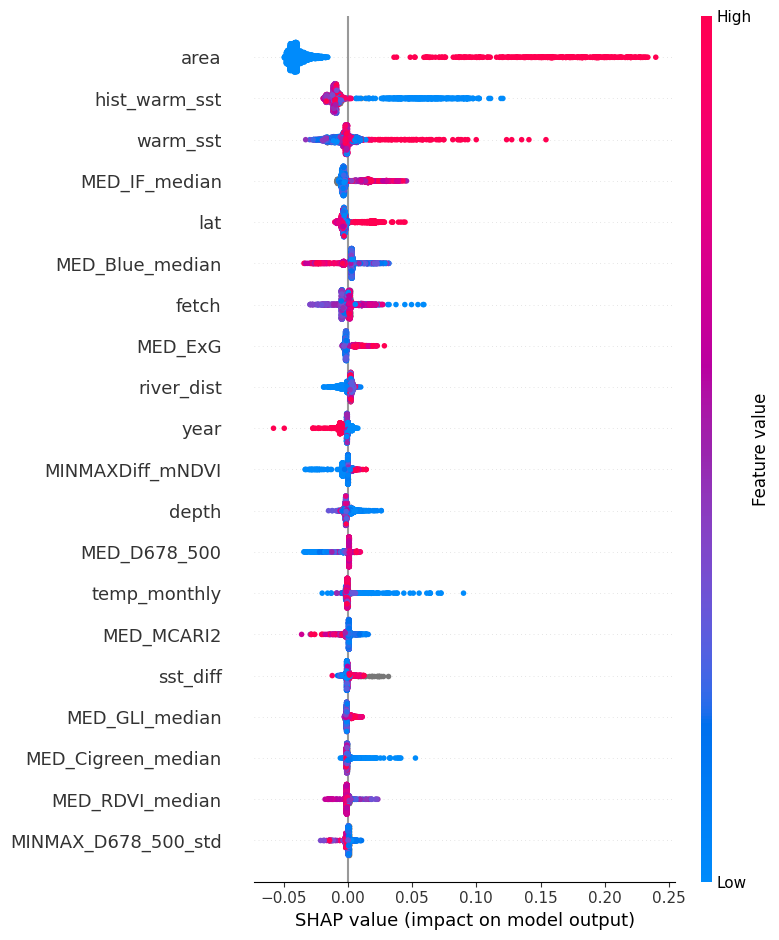

##############################
● CV1
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00155366
[1000]	valid_0's fair: 0.00152383
[1500]	valid_0's fair: 0.00151812
[2000]	valid_0's fair: 0.00151651
Early stopping, best iteration is:
[2295]	valid_0's fair: 0.00151587
0.163161484300093


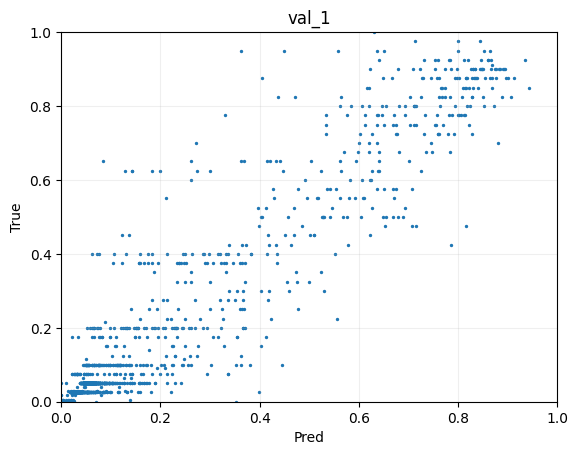

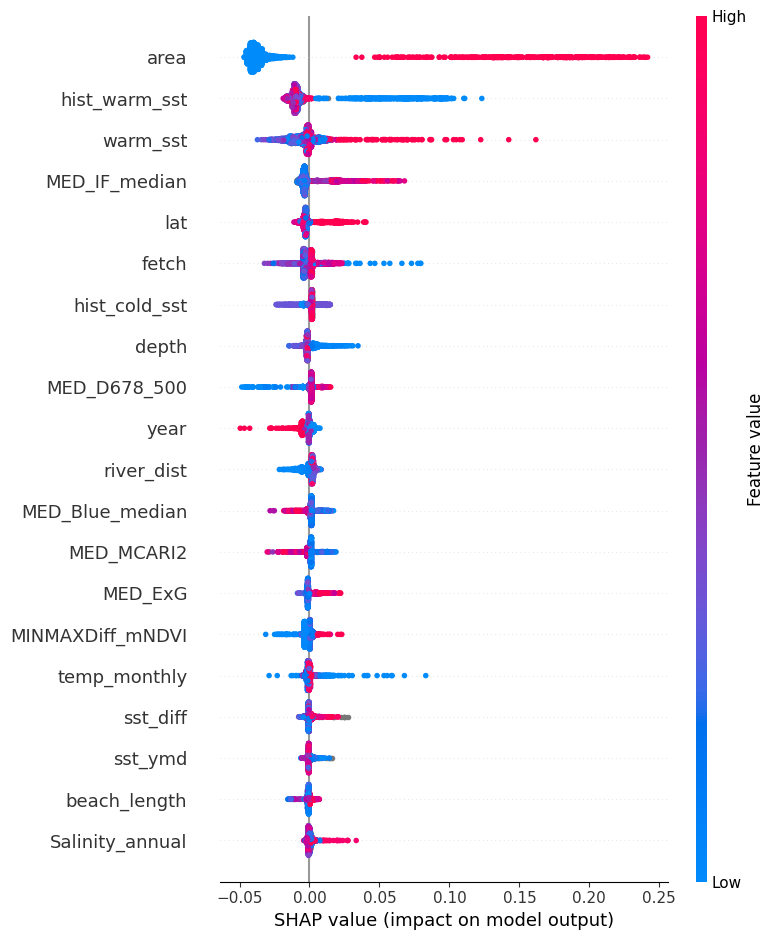

##############################
● CV2
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00164698
[1000]	valid_0's fair: 0.00162138
[1500]	valid_0's fair: 0.00161638
[2000]	valid_0's fair: 0.00161537
Early stopping, best iteration is:
[1975]	valid_0's fair: 0.00161534
0.1496296428274112


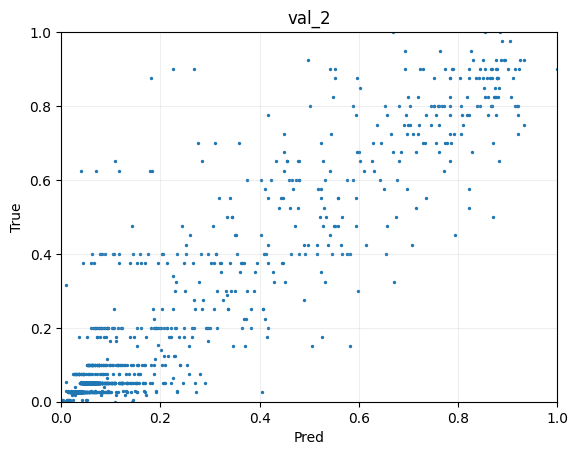

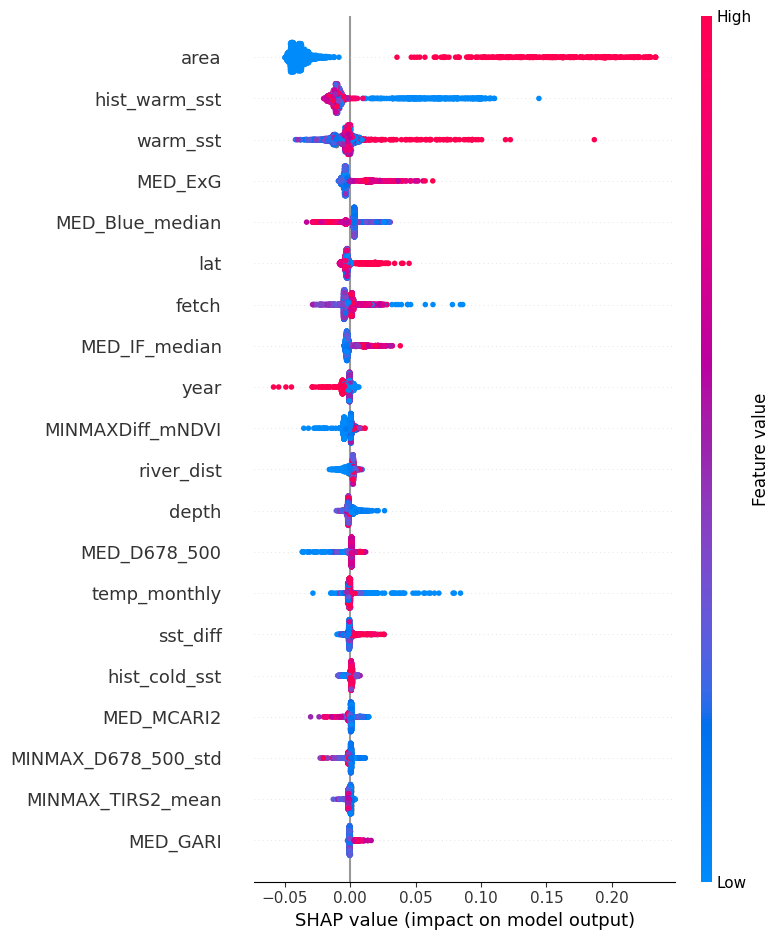

##############################
● CV3
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00163666
Early stopping, best iteration is:
[761]	valid_0's fair: 0.00162272
0.14876647697765463


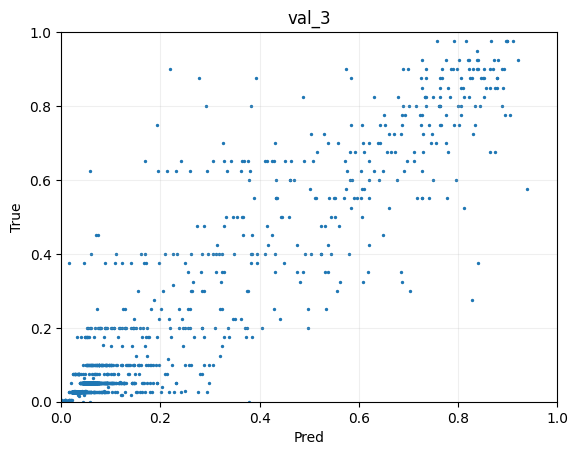

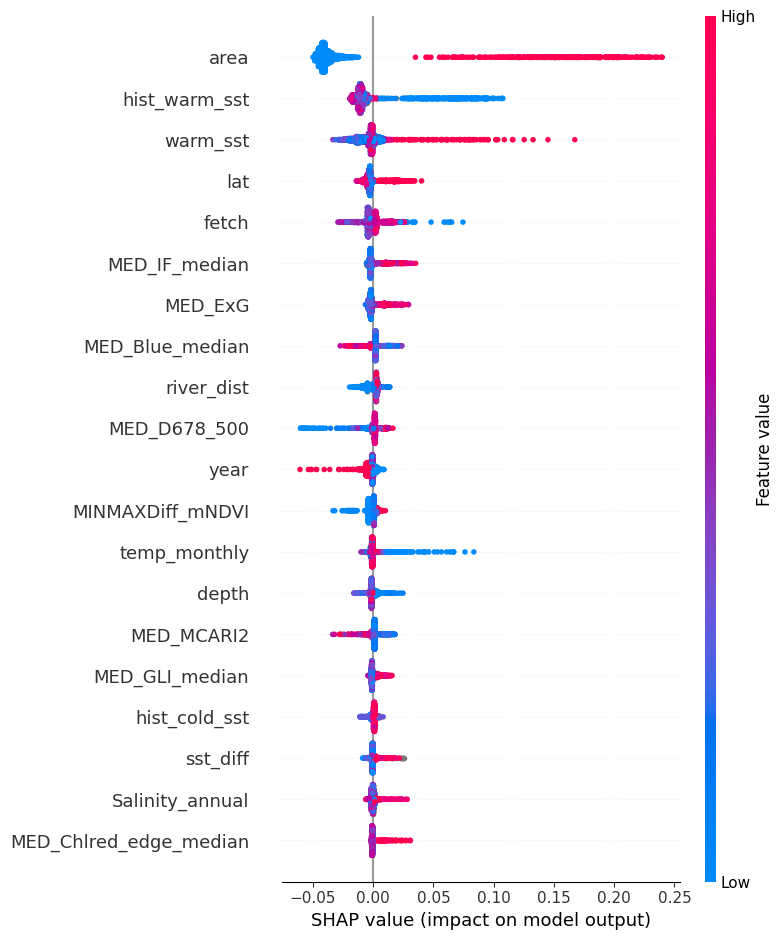

##############################
● CV4
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00146112
[1000]	valid_0's fair: 0.00143778
Early stopping, best iteration is:
[1231]	valid_0's fair: 0.00143544
0.1490687675958947


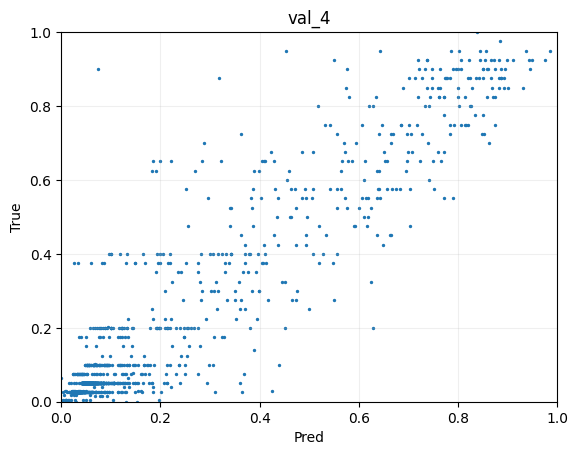

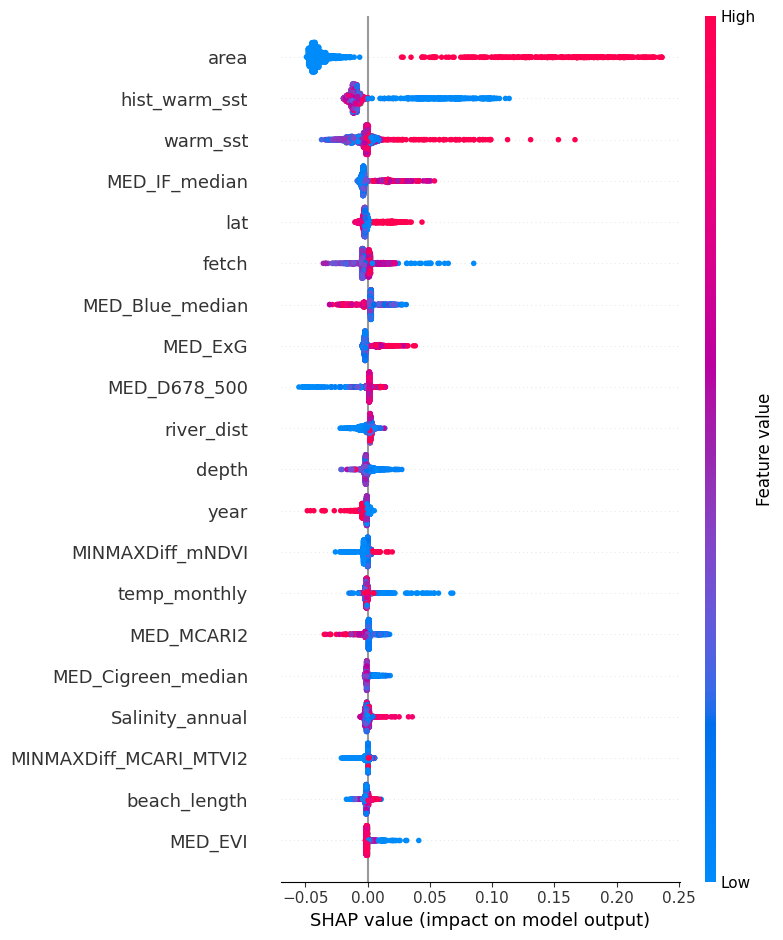

##############################
学習曲線
##############################


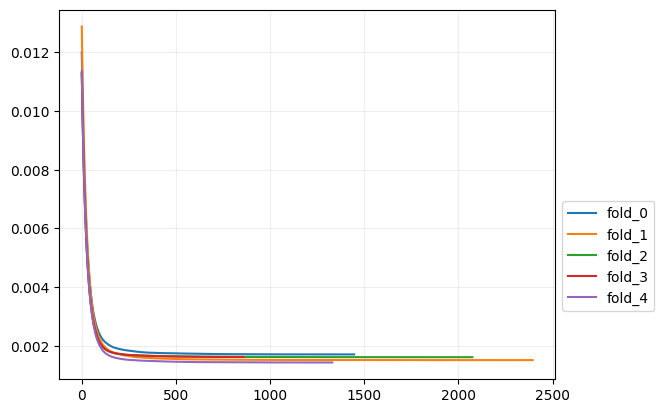

In [24]:
idx_null_depth_original = train["depth_original"].isnull()
idx_null_depth_original_test = test["depth_original"].isnull()

train_mod = train[idx_null_depth_original]
test_mod = test[idx_null_depth_original_test]

# 説明変数からdepth_original抜く
features_mod = [col for col in features if not col=="depth_original"]
print("説明変数の数（修正前）", len(features))
print("説明変数の数（修正後）", len(features_mod))

results_rmse, fi_df, y_test_pred, y_val_pred = my_cross_val_predict(train_mod, test_mod, y_name="log_cover", y_raw_name="cover", params=params, features=features_mod)

In [25]:
y_test_pred_final[idx_null_depth_original_test.values] = y_test_pred
y_val_pred_final[idx_null_depth_original.values] = y_val_pred

CV0: 0.086
CV1: 0.080
CV2: 0.083
CV3: 0.083
CV4: 0.077
Average: 0.082


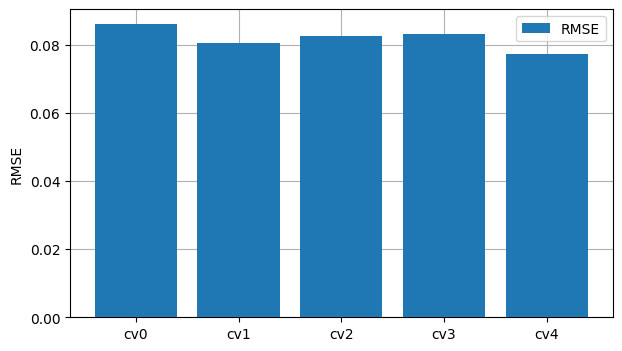

In [26]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 349)


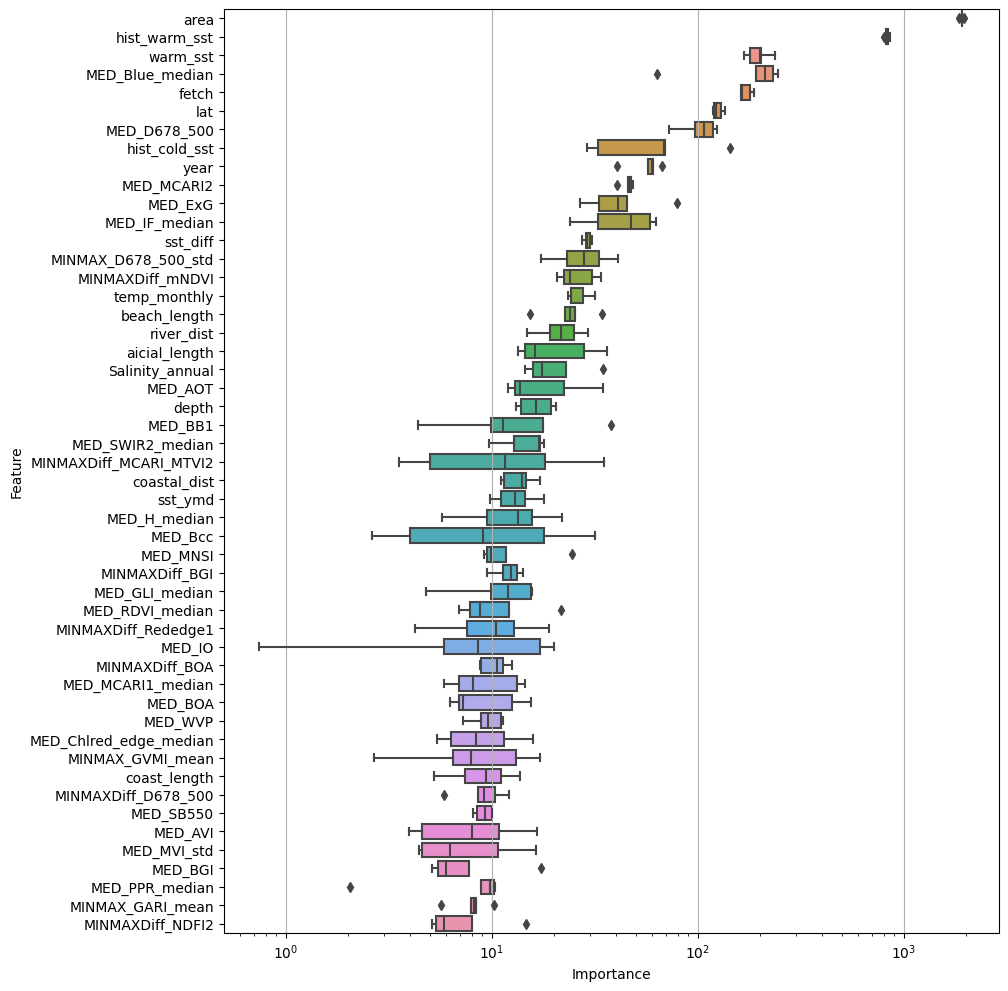

In [27]:
plot_importance(fi_df, figsize=(10, 12))

## パターン2（depth_originalあり）

In [28]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 10, 
    'n_estimators': 4000, 
    'learning_rate': 0.017249570940885327, 
    'lambda_l1': 0.07458308290764872, 
    'num_leaves': 170, 
    'colsample_bytree': 0.6731079655436575,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

##############################
● CV0
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00519082
[1000]	valid_0's fair: 0.00509224
[1500]	valid_0's fair: 0.00507387
Early stopping, best iteration is:
[1763]	valid_0's fair: 0.00506987
0.2233113210454489


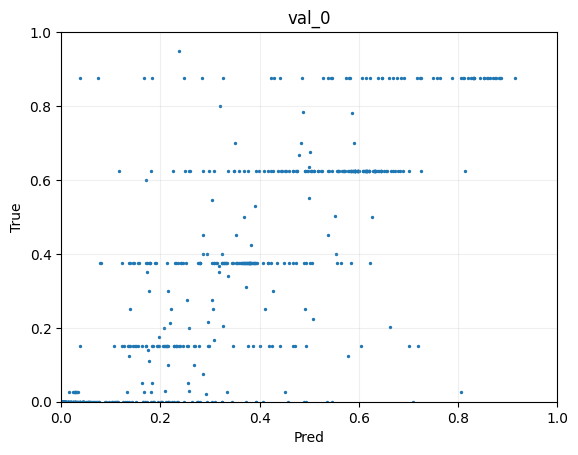

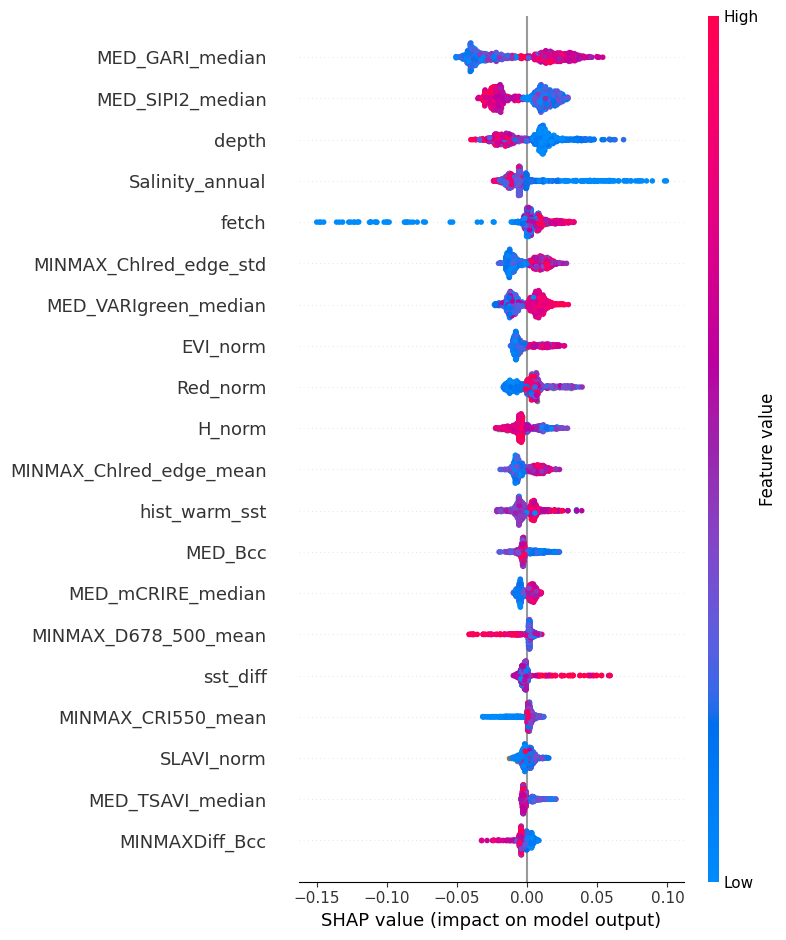

##############################
● CV1
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00572086
Early stopping, best iteration is:
[789]	valid_0's fair: 0.00566576
0.2373034912211972


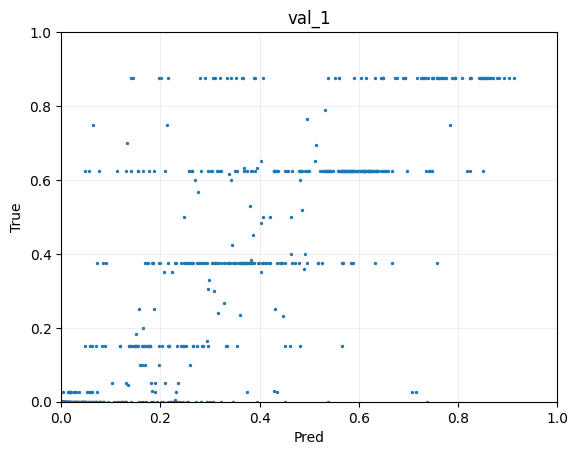

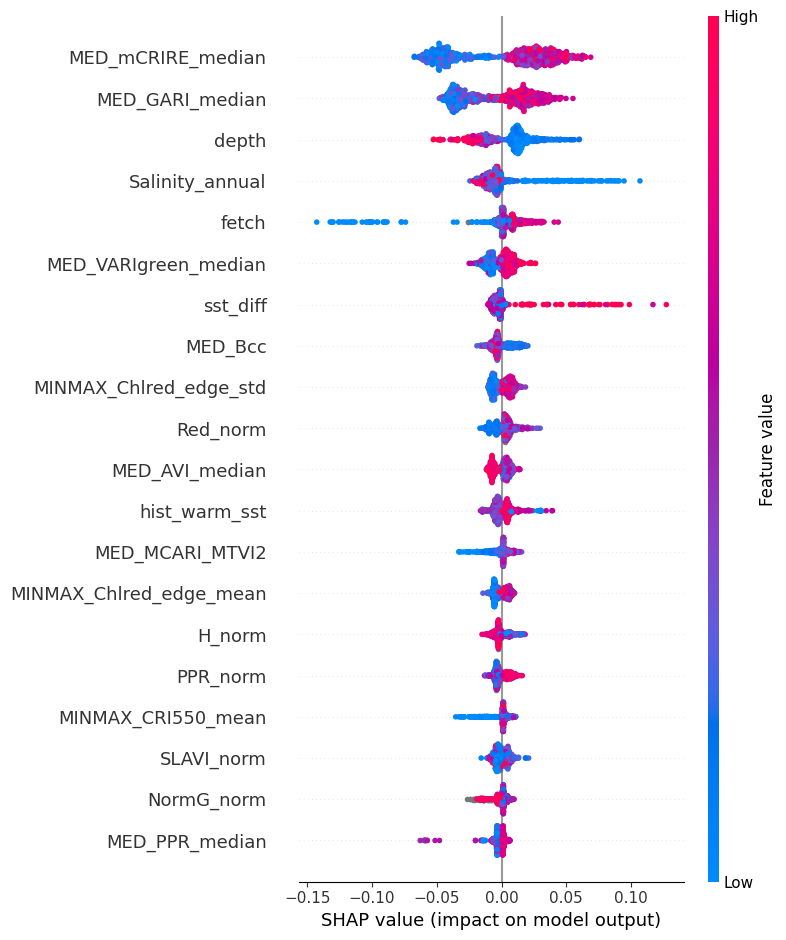

##############################
● CV2
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00488234
[1000]	valid_0's fair: 0.00471255
[1500]	valid_0's fair: 0.00468848
[2000]	valid_0's fair: 0.00467934
Early stopping, best iteration is:
[2384]	valid_0's fair: 0.00467633
0.24357142634508863


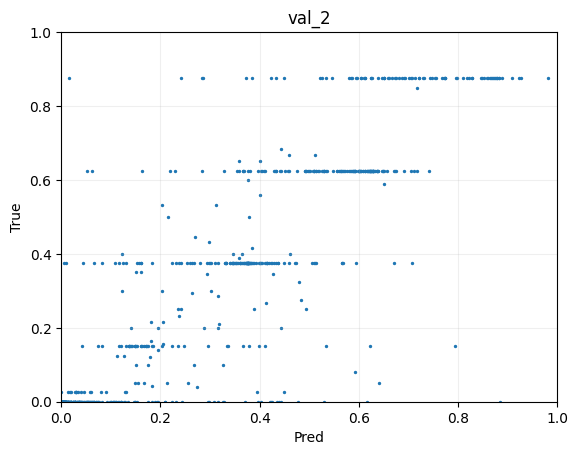

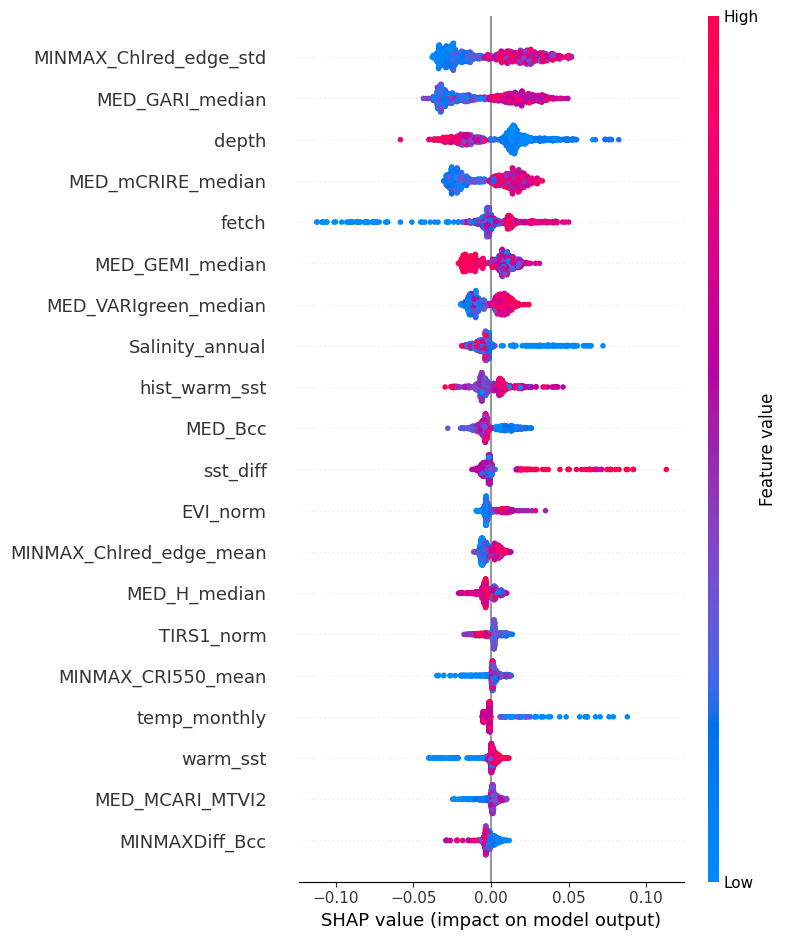

##############################
● CV3
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00531203
[1000]	valid_0's fair: 0.0051222
[1500]	valid_0's fair: 0.00508321
Early stopping, best iteration is:
[1848]	valid_0's fair: 0.00507878
0.24612774144007898


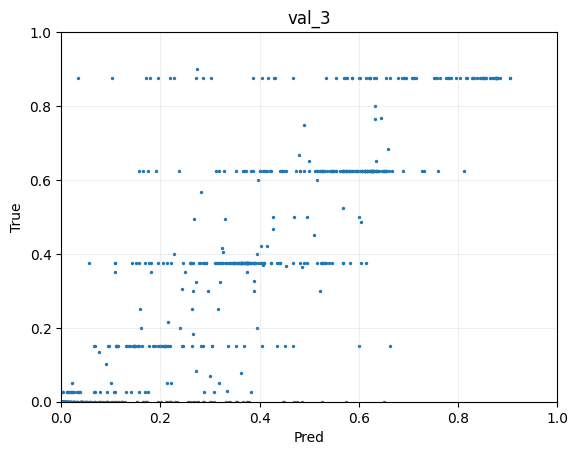

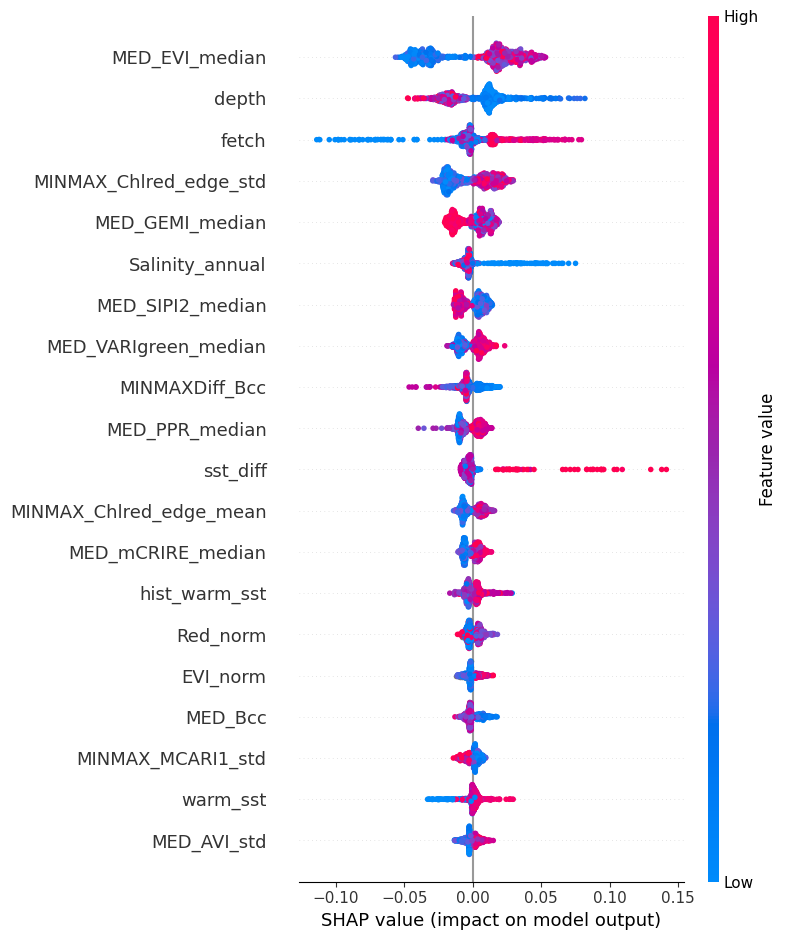

##############################
● CV4
##############################
Training until validation scores don't improve for 100 rounds
[500]	valid_0's fair: 0.00481237
[1000]	valid_0's fair: 0.0047617
Early stopping, best iteration is:
[1050]	valid_0's fair: 0.00475899
0.22821064154455753


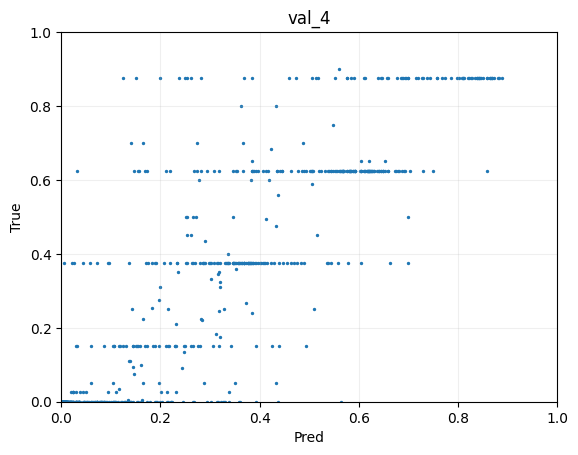

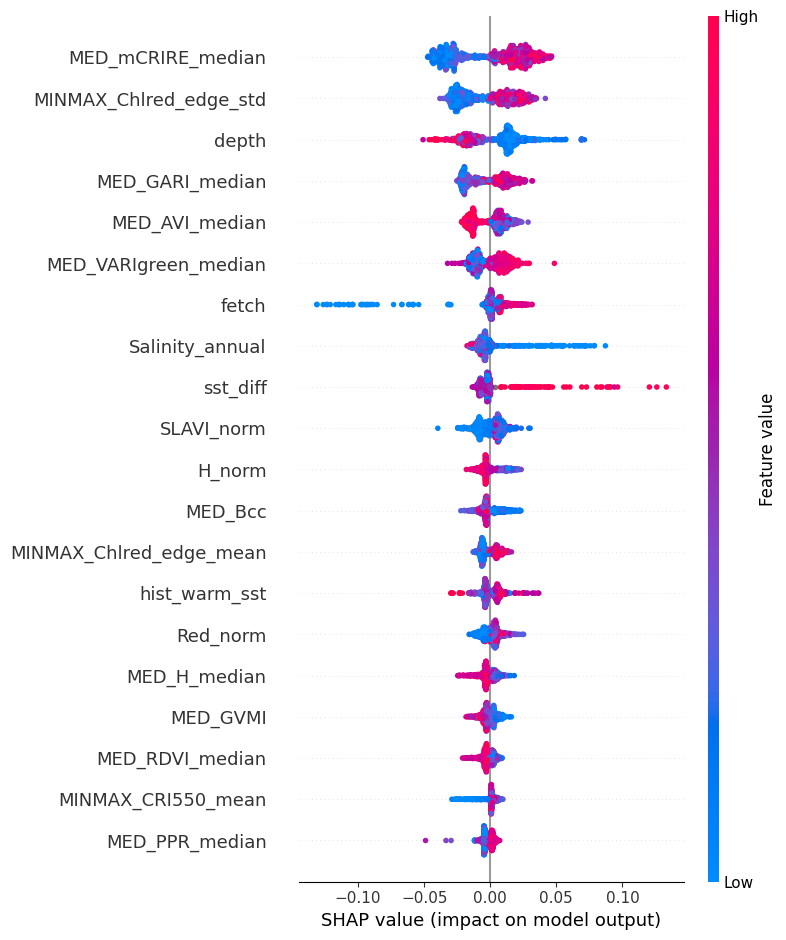

##############################
学習曲線
##############################


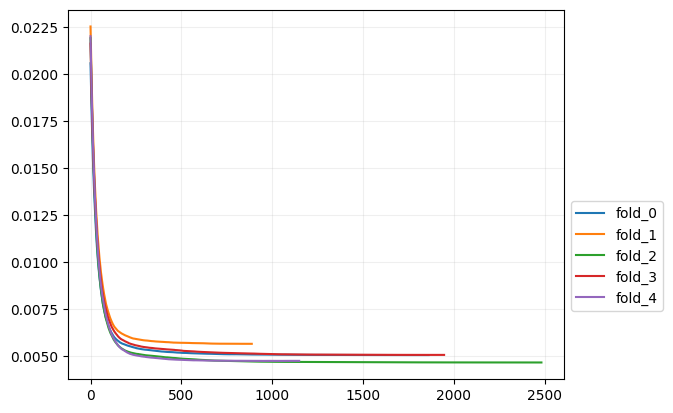

In [29]:
idx_nonnull_depth_original = ~idx_null_depth_original
idx_nonnull_depth_original_test = ~idx_null_depth_original_test

train_mod = train[idx_nonnull_depth_original]
test_mod = test[idx_nonnull_depth_original_test]

results_rmse, fi_df, y_test_pred, y_val_pred = my_cross_val_predict(train_mod, test_mod, y_name="log_cover", y_raw_name="cover", params=params, features=features)

In [30]:
y_test_pred_final[idx_nonnull_depth_original_test.values] = y_test_pred
y_val_pred_final[idx_nonnull_depth_original.values] = y_val_pred

CV0: 0.149
CV1: 0.161
CV2: 0.143
CV3: 0.149
CV4: 0.145
Average: 0.149


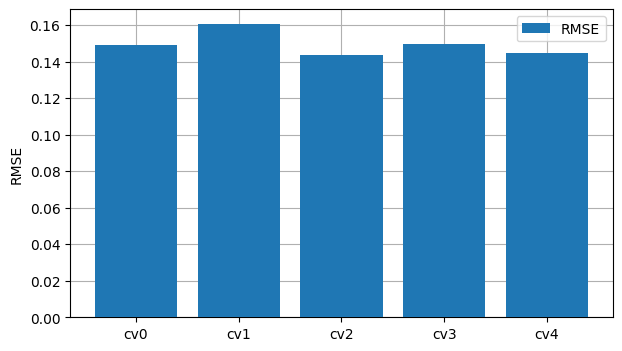

In [31]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 350)


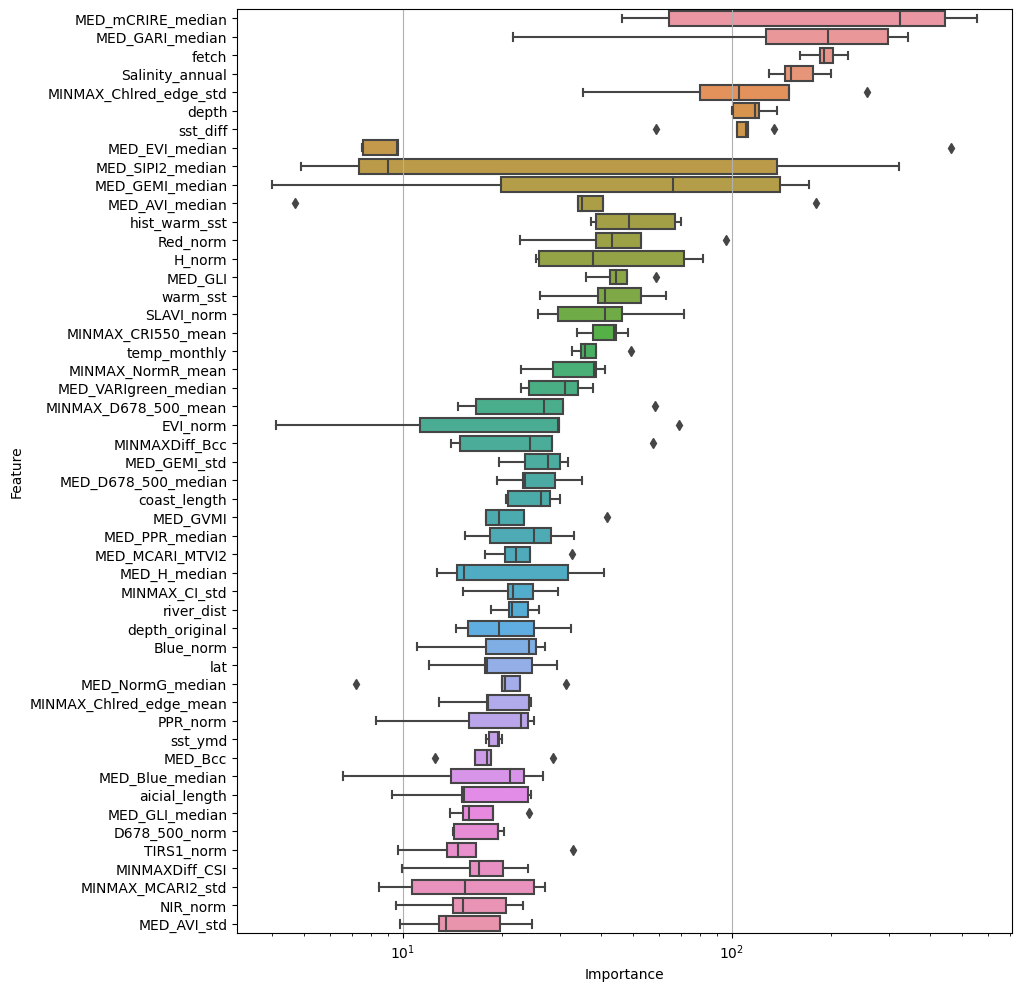

In [32]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [33]:
test_sub = pd.DataFrame(y_test_pred_final, columns=["pred"])
test_sub

,pred
0,0.274082
1,0.107620
2,0.275227
3,0.050521
4,0.119985
...,...
4034,0.148425
4035,0.051788
4036,0.288076
4037,0.068547


In [34]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.19080031854665253

In [35]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.174162
1,0.007700
2,0.175307
3,0.000000
4,0.020065
...,...
4034,0.048505
4035,0.000000
4036,0.188156
4037,0.000000


In [36]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.019907313897537356
pred_最大値: 0.7976981460741509
pred_平均値: 0.19080031854665253


In [37]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.6977778275274984
pred_平均値: 0.10861200731490234


In [51]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)

# 予測結果確認

In [39]:
def check_by_scatter(check_col):
    tmp1 = df_pred[train[check_col].isnull()]
    tmp2 = df_pred[~train[check_col].isnull()]
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.grid(alpha=0.2, color="gray")
    ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"NOT Null", alpha=0.5)
    ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Null", alpha=0.5)
    ax.set_xlabel("Pred")
    ax.set_ylabel("True")
    ax.set_title(check_col)
    ax.legend()
    plt.show()

In [40]:
train["y_pred"] = y_val_pred_final
df_pred = train[["cover", "y_pred"]]
score = np.sqrt(mean_squared_error(train['cover'].values, train['y_pred'].values))
print(f"全体のRMSE: {score:.04f}")

全体のRMSE: 0.1077


In [41]:
# check_col = "depth_original"
# tmp1 = df_pred[train[check_col].isnull()]
# tmp2 = df_pred[~train[check_col].isnull()]
# score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
# score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
# print(f"●全体のRMSE ({check_col}がnull)")
# print(f"　データ数: {len(tmp1)}")
# print(f"　スコア: {score1:.04f}\n")
# print(f"●全体のRMSE ({check_col}がnull以外)")
# print(f"　データ数: {len(tmp2)}")
# print(f"　スコア: {score2:.04f}\n")
# print(f"テストデータで{check_col}がnullの割合")
# print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
# check_by_scatter(check_col)

In [42]:
# check_col = "Blue"
# tmp1 = df_pred[train[check_col].isnull()]
# tmp2 = df_pred[~train[check_col].isnull()]
# score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
# score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
# print(f"●全体のRMSE ({check_col}がnull)")
# print(f"　データ数: {len(tmp1)}")
# print(f"　スコア: {score1:.04f}\n")
# print(f"●全体のRMSE ({check_col}がnull以外)")
# print(f"　データ数: {len(tmp2)}")
# print(f"　スコア: {score2:.04f}\n")
# print(f"テストデータで{check_col}がnullの割合")
# print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
# check_by_scatter(check_col)

In [43]:
# check_col = "MED_AFRI1600"
# tmp1 = df_pred[train[check_col].isnull()]
# tmp2 = df_pred[~train[check_col].isnull()]
# score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
# score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
# print(f"●全体のRMSE ({check_col}がnull)")
# print(f"　データ数: {len(tmp1)}")
# print(f"　スコア: {score1:.04f}\n")
# print(f"●全体のRMSE ({check_col}がnull以外)")
# print(f"　データ数: {len(tmp2)}")
# print(f"　スコア: {score2:.04f}\n")
# print(f"テストデータで{check_col}がnullの割合")
# print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
# check_by_scatter(check_col)

In [44]:
# check_col = "MAX_NormG__median"
# tmp1 = df_pred[train[check_col].isnull()]
# tmp2 = df_pred[~train[check_col].isnull()]
# score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
# score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
# print(f"●全体のRMSE ({check_col}がnull)")
# print(f"　データ数: {len(tmp1)}")
# print(f"　スコア: {score1:.04f}\n")
# print(f"●全体のRMSE ({check_col}がnull以外)")
# print(f"　データ数: {len(tmp2)}")
# print(f"　スコア: {score2:.04f}\n")
# print(f"テストデータで{check_col}がnullの割合")
# print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
# check_by_scatter(check_col)

In [45]:
# check_col = "depth"
# tmp1 = df_pred[train[check_col].isnull()]
# tmp2 = df_pred[~train[check_col].isnull()]
# score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
# score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
# print(f"●全体のRMSE ({check_col}がnull)")
# print(f"　データ数: {len(tmp1)}")
# print(f"　スコア: {score1:.04f}\n")
# print(f"●全体のRMSE ({check_col}がnull以外)")
# print(f"　データ数: {len(tmp2)}")
# print(f"　スコア: {score2:.04f}\n")
# print(f"テストデータで{check_col}がnullの割合")
# print(f"　{(100*test[check_col].isnull().sum()/len(test)):.3f}%")
# check_by_scatter(check_col)

In [46]:
# check_col = "Landsat_num"
# tmp1 = df_pred[train[check_col]==7]
# tmp2 = df_pred[train[check_col]==8]
# score1 = np.sqrt(mean_squared_error(tmp1['cover'].values, tmp1['y_pred'].values))
# score2 = np.sqrt(mean_squared_error(tmp2['cover'].values, tmp2['y_pred'].values))
# print(f"●全体のRMSE ({check_col}==7)")
# print(f"　データ数: {len(tmp1)}")
# print(f"　スコア: {score1:.04f}\n")
# print(f"●全体のRMSE ({check_col}==8)")
# print(f"　データ数: {len(tmp2)}")
# print(f"　スコア: {score2:.04f}\n")
# print(f"テストデータで{check_col}==7の割合")
# print(f"　{(100*(test[check_col]==7).sum()/len(test)):.3f}%")

# fig, ax = plt.subplots(figsize=(7, 6))
# ax.grid(alpha=0.2, color="gray")
# ax.scatter(tmp2["y_pred"], tmp2["cover"], s=6, label=f"Landsat_num==8", alpha=0.5)
# ax.scatter(tmp1["y_pred"], tmp1["cover"], s=6, label=f"Landsat_num==7", alpha=0.5)
# ax.set_xlabel("Pred")
# ax.set_ylabel("True")
# ax.set_title(check_col)
# ax.legend()
# plt.show()

In [49]:
if SAVE_DF:
    train.to_pickle(SAVE_DF_DIR / f"train_predicted_{SUB_FILE_NAME}.pkl")